In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob

In [11]:
def load_benchmark(pattern, skip_warmup=3, zscore_threshold=2.5):
    frames = []
    for path in sorted(glob.glob(pattern)):
        df = pd.read_csv(path).iloc[skip_warmup:]
        frames.append(df)

    df = pd.concat(frames, ignore_index=True)

    def drop_outliers(group):
        for col in group.select_dtypes(include=np.number).columns:
            if col == 'sphere_count': continue
            z = np.abs((group[col] - group[col].mean()) / (group[col].std() + 1e-9))
            group = group[z < zscore_threshold]
        return group

    df = df.groupby('sphere_count', group_keys=False).apply(drop_outliers)
    return df.groupby('sphere_count').mean(numeric_only=True)

epipolar = load_benchmark('.\\data\\*epipolar_benchmark.csv')
physics  = load_benchmark('.\\data\\*physics_benchmark.csv')

epipolar['speedup'] = epipolar['cpu_compute_ms'] / epipolar['gpu_compute_ms']
physics['speedup']  = physics['cpu_physics_ms']  / physics['gpu_physics_ms']

print(epipolar[['gpu_compute_ms', 'cpu_compute_ms', 'speedup']].round(3))
print(physics[['gpu_physics_ms', 'cpu_physics_ms', 'speedup']].round(3))

              gpu_compute_ms  cpu_compute_ms  speedup
sphere_count                                         
3                      0.023           0.655   28.496
10                     0.044           0.977   22.213
25                     0.091           1.484   16.386
50                     0.168           2.363   14.065
75                     0.243           3.089   12.737
100                    0.320           4.008   12.526
250                    0.999           9.188    9.194
500                    1.809          17.229    9.525
750                    2.619          25.832    9.864
1000                   3.412          33.947    9.950
1250                   4.404          41.142    9.341
1500                   5.061          50.163    9.912
2000                   6.997          66.417    9.492
2500                   8.404          81.750    9.727
3000                  10.377          98.431    9.485
3500                  11.503         114.753    9.976
3750                  11.949

C:\Users\liamc\AppData\Local\Temp\ipykernel_15828\3504059802.py:16: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('sphere_count', group_keys=False).apply(drop_outliers)
C:\Users\liamc\AppData\Local\Temp\ipykernel_15828\3504059802.py:16: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('sphere_count', group_keys=False).apply(drop_outliers)


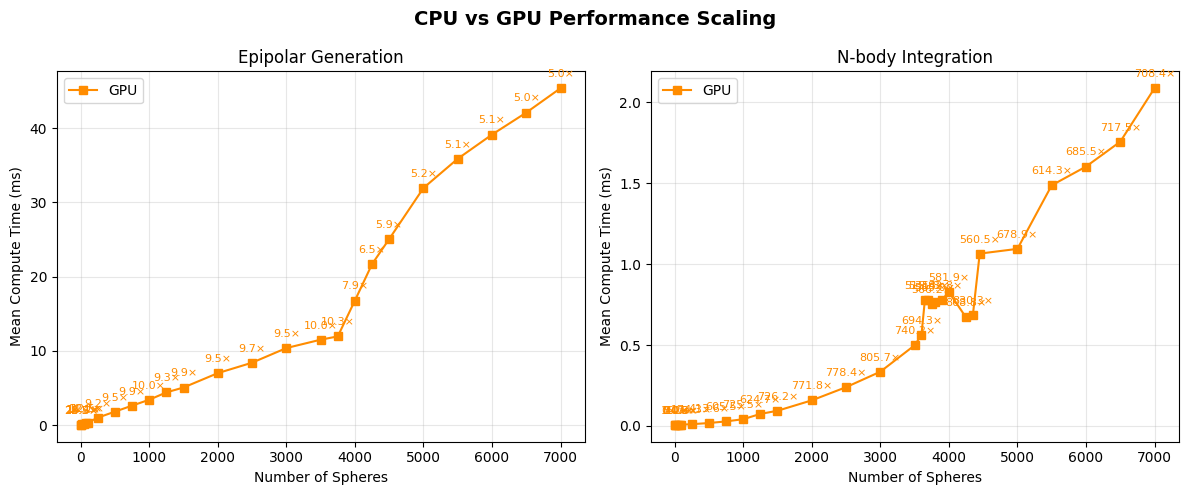

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('CPU vs GPU Performance Scaling', fontsize=14, fontweight='bold')

for ax, df, gpu_col, cpu_col, title in [
    (axes[0], epipolar, 'gpu_compute_ms', 'cpu_compute_ms', 'Epipolar Generation'),
    (axes[1], physics,  'gpu_physics_ms', 'cpu_physics_ms', 'N-body Integration'),
]:
    #ax.plot(df.index, df[cpu_col], 'o-', label='CPU', color='steelblue')
    ax.plot(df.index, df[gpu_col], 's-', label='GPU', color='darkorange')
    ax.set_title(title)
    ax.set_xlabel('Number of Spheres')
    ax.set_ylabel('Mean Compute Time (ms)')
    ax.legend()
    ax.grid(True, alpha=0.3)

    for n in df.index:
        ax.annotate(f'{df.loc[n, "speedup"]:.1f}×',
                    xy=(n, df.loc[n, gpu_col]),
                    xytext=(0, 8), textcoords='offset points',
                    ha='center', fontsize=8, color='darkorange')

plt.tight_layout()
plt.savefig('benchmark_plot.png', dpi=150, bbox_inches='tight')
plt.show()

C:\Users\liamc\AppData\Local\Temp\ipykernel_15828\1202032262.py:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


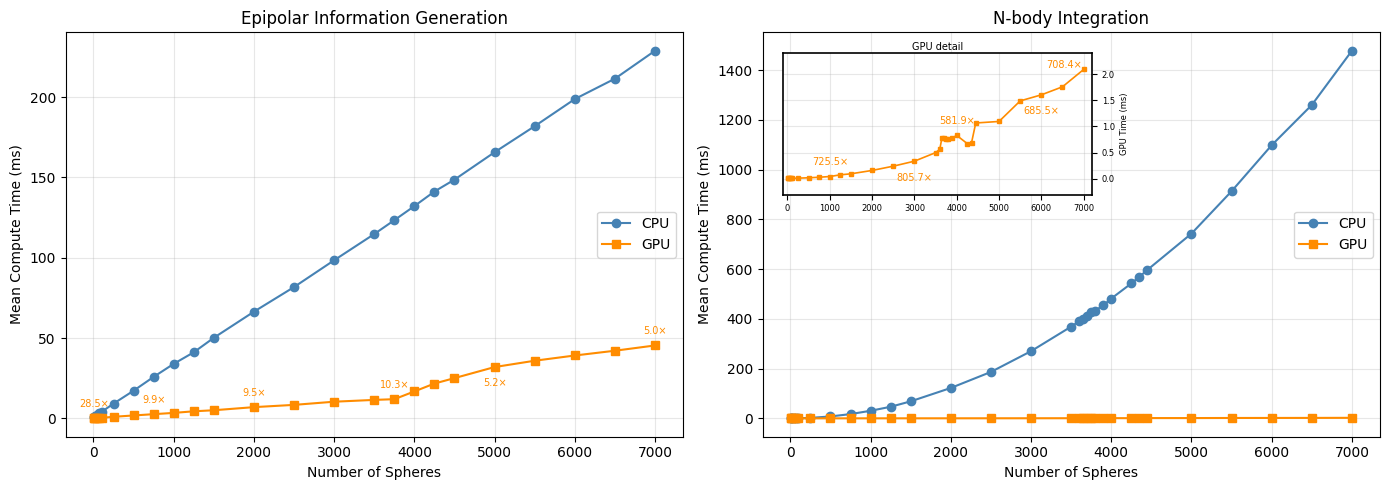

In [13]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
#fig.suptitle('CPU vs GPU Performance Scaling', fontsize=14, fontweight='bold')

for ax, df, gpu_col, cpu_col, title in [
    (axes[0], epipolar, 'gpu_compute_ms', 'cpu_compute_ms', 'Epipolar Information Generation'),
    (axes[1], physics,  'gpu_physics_ms', 'cpu_physics_ms', 'N-body Integration'),
]:
    ax.plot(df.index, df[cpu_col], 'o-', label='CPU', color='steelblue')
    ax.plot(df.index, df[gpu_col], 's-', label='GPU', color='darkorange')
    ax.set_title(title)
    ax.set_xlabel('Number of Spheres')
    ax.set_ylabel('Mean Compute Time (ms)')
    ax.legend(loc='center right')
    ax.grid(True, alpha=0.3)

ax = axes[0]
df, gpu_col = epipolar, 'gpu_compute_ms'
for i, n in enumerate(df.index):
    if i % 4 == 0 and i != 4:
        offset = 8 if df.loc[n, gpu_col] < 10 else (8 if i % 8 == 0 else -14)
        ax.annotate(f'{df.loc[n, "speedup"]:.1f}×',
                    xy=(n, df.loc[n, gpu_col]),
                    xytext=(0, offset), textcoords='offset points',
                    ha='center', fontsize=7, color='darkorange')

ax = axes[1]
df, gpu_col = physics, 'gpu_physics_ms'

axins = inset_axes(ax, width='50%', height='35%', loc='upper left', borderpad=1.5)
axins.plot(df.index, df[gpu_col], 's-', color='darkorange', linewidth=1.2, markersize=3)


target_ns = [1000, 3000, 4000, 6000, 7000]
annotated = []
for i_t, n_target in enumerate(target_ns):
    n = df.index[np.argmin(np.abs(df.index - n_target))]
    if n in annotated:
        continue
    annotated.append(n)
    offset = 8 if i_t % 2 == 0 else -14
    if n_target == 7000:
        axins.annotate(f'{df.loc[n, "speedup"]:.1f}×',
                       xy=(n, df.loc[n, gpu_col]),
                       xytext=(-1, 1), textcoords='offset points',
                       ha='right', fontsize=7, color='darkorange')
    else:
        axins.annotate(f'{df.loc[n, "speedup"]:.1f}×',
                       xy=(n, df.loc[n, gpu_col]),
                       xytext=(0, offset), textcoords='offset points',
                       ha='center', fontsize=7, color='darkorange')

gpu_min, gpu_max = df[gpu_col].min(), df[gpu_col].max()
margin = (gpu_max - gpu_min) * 0.15
axins.set_xlim(df.index[0] - 100, df.index[-1] + 200)
axins.set_ylim(gpu_min - margin, gpu_max + margin)
axins.set_title('GPU detail', fontsize=7, pad=2)
axins.tick_params(labelsize=6)
axins.grid(True, alpha=0.3)

axins.yaxis.set_label_position('right')
axins.yaxis.tick_right()
axins.set_ylabel('GPU Time (ms)', fontsize=6)

for spine in axins.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.2)

plt.tight_layout()
plt.savefig('benchmark_plot.png', dpi=150, bbox_inches='tight')
plt.show()